all done


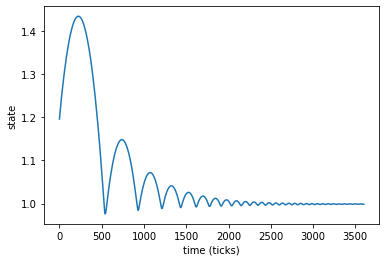

In [15]:
## Simulate the walker with some sort of tracking controller about the trajectory generated above
#%tb
import pydrake
from seagul.drake import y_float_prism

import math
import numpy as np
import matplotlib.pyplot as plt

from pydrake.all import (BasicVector, DiagramBuilder, FloatingBaseType,
                         RigidBodyPlant, RigidBodyTree, Simulator,SignalLogger, 
                         Isometry3, DirectCollocation, PiecewisePolynomial, VectorSystem)
from pydrake.solvers.mathematicalprogram import Solve

from pydrake.attic.multibody.shapes import VisualElement, Box
from pydrake.attic.multibody.collision import CollisionElement

#from pydrake.all import 
from underactuated import (FindResource, PlanarRigidBodyVisualizer)

from IPython.display import HTML
import matplotlib.pyplot as plt

#this one is home grown, make sure it's in the same directory as this notebook
from seagul.drake import x_expr,y_expr,x_float,y_float,x_taylor,y_taylor
from seagul.resources import getResourcePath 
from numpy import pi
    
# set up the walker and the ground
#==============================================================================

#load the walker 
tree = RigidBodyTree(FindResource(getResourcePath() + "/sphere.urdf"), FloatingBaseType.kFixed)

box_depth = 100
X = Isometry3(rotation=np.identity(3), translation=[0, 0, -5.])
                
color = np.array([0.9297, 0.7930, 0.6758, 1])
tree.world().AddVisualElement(VisualElement(Box([100., 10., 10.]), X, color))
tree.addCollisionElement(CollisionElement(Box([100., 10., 10.]), X), tree.world(), "the_ground")

tree.compile()

builder = DiagramBuilder()
robot = builder.AddSystem(RigidBodyPlant(tree))

# set the friction properties
material = pydrake.attic.multibody.rigid_body_plant.CompliantMaterial(1e8,.32,.7,.6) #TODO 
robot.set_default_compliant_material(material)

#controller = builder.AddSystem(tracking_controller(u_lookup, x_lookup))
#controller  = builder.AddSystem(pfl_controller(times, u_lin, x_lookup,  kp=7000, kd=700))
#controller  = builder.AddSystem(passive_controller())


state_logger = builder.AddSystem(SignalLogger(robot.get_output_port(0).size()))
state_logger.DeclarePeriodicPublish(1.0 / 30.0, 0.0)

#u_logger = builder.AddSystem(SignalLogger(controller.get_output_port(0).size()))
#u_logger.DeclarePeriodicPublish(1.0 / 30.0, 0.0)


builder.Connect(robot.get_output_port(0), state_logger.get_input_port(0))
#builder.Connect(controller.get_output_port(0), u_logger.get_input_port(0))
#builder.Connect(robot.get_output_port(0), controller.get_input_port(0))
#builder.Connect(controller.get_output_port(0), robot.get_input_port(0))

diagram = builder.Build()

simulator = Simulator(diagram)
simulator.set_publish_every_time_step(False)
integrator = simulator.get_integrator()
integrator.set_fixed_step_mode(True)
integrator.set_maximum_step_size(.001)

context = simulator.get_mutable_context()
state = context.get_mutable_continuous_state_vector()

init_xyz = np.array([0,0,10]).reshape(-1,1)
init_rpy = np.array([0,0,0]).reshape(-1,1)
init_dxyz = np.array([0,0,0]).reshape(-1,1)
init_drpy = np.array([0,0,0]).reshape(-1,1)

init_state = np.concatenate((init_xyz, init_rpy, init_dxyz, init_drpy))
#init_state = np.array([1,1,1,0,0,0])
state.SetFromVector(init_state)  # initial condition


simulator.StepTo(5)
print("all done")

plt.figure()
plt.plot(state_logger.data().transpose(1,0)[1500:,2])
plt.xlabel('time (ticks)')
plt.ylabel('state')

prbv = PlanarRigidBodyVisualizer(tree, xlim=[-2.5, 2.5], ylim=[-5, 2.5])
ani = prbv.animate(state_logger, repeat=True)
plt.close(prbv.fig)
HTML(ani.to_html5_video())